In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import matplotlib.ticker as mtick
import numpy as np
from scipy import signal
from quantiphy import Quantity #to format numbers 

## Introduction

* This notebooks aims to generate a pulse train waveform to transmit binary polar data;
* A comparison between several pulse shapes is made in the frequency domain;

### Generating the sinc function in time domain
* Given a bandwidth and a sampling rate, create a sinc pulse  $p(t)$ in the time domain;
* This pulse will be used to modulate data given a certain modulation scheme;
* Because of the sinc function peculiarities, we will have to generate a pulse with several samples, then decimate it to a more reliable sampling rate.

The equation of the sinc function is:

$p(t) =  sinc \left ( \pi R_b t \right )$

Where:
- $R_b$ is the bandwidth of the signal;
- $sinc$ in numpy refers to $sinc(t) = \frac{\sin(\pi t) }{ \pi t}$

In the frequecy domain, the sinc signal $p(t)$ transforms into as a rectangular spectrum, defined by the following equation:

$\chi \{ p(t) \} = \dfrac{1}{R_B}rect \left ( \dfrac{f}{R_b} \right ) $

Where:
* $\chi \{ \}$ stands for the Fourier Transform operation;
* $rect$ stands for the rectangular pulse function.

The $rect$ function is described by the following expression:

$rect \left ( \dfrac{f}{R_b}\right ) =  \begin{cases}1 & -R_b/2 \geq \omega \geq R_b/2 \\
0 & \mathrm{otherwise} \\
\end{cases}$


## Establishing initial Parameters

* The code below shows the selection of the initial parameters to shape the pulse;
* **Extra care** should be taken in this part, as it will define the behavior of the pulse in both time and frequency domains;
* The pulse will be used to make an impulse response of the pulse shape to be transmitted;
* For this, it will need to be decimated over a reliable sampling frequency;
* The pulse is defined by a rate $R_b$ (in Hz), which is $T_b = 1/R_b$, where $T_b$ is the duration of the main lobe pulse in time;
* $R_b$ Also stands for the desired data-rate of baseband transmission;
* Hence, in the code below, the variable "oversamp" indicates the number of times the time window of the pulse will be reproduced in order to form the total pulse width in time;
* Code was written so that "f_sampling" and "oversamp" are threated separetely in order to highlight the **Nyquist Sampling Theorem**.

### A note on the delay of the pulse

For the filter to be physically reliable, it needs to be causal. Meaning, its impulse response must be 0 for $t < 0$. This can be achieved by adding a time displacement delay to the impulse response, $t_d$, "t_disp" in our set of variables.

Lathi [1] affirms that the greater the delay, the closer the filter will get to its ideal mathematical form. Ideally, we would have to wait until infinity, $t_d = \infty$, to have our ideal pulse. Of course, this is unreliable. Therefore, a delay on the filter impulse response must be selected.

In practical terms, this means that the delay shift of the pulse implies in two costs:

    1) The greater the delay, the greater the number of samples in the filter window;
    2) The greater the delay, the greater the computing costs in synchronization at the receiver;

Thus, in order to achieve a better filter resolution, we pay for a greater sampling rate and also a transmission delay.

Moreover, as also stated by Lathi [1], the usual delay employed for the filter is 3 to 4 times $1/2R_b$. For instance, for a 20 KHz bandwidth, a recommended delay would be $t_d = 10^{-4} \;\mathrm{ ms}$. Hence, this will be our rule of thumb for this variable.

## Generating the signal

In [2]:
#initial parameters
Rb = 20e3 #Bandwidth of pulse signal in Hz
k = 64 #upsampling factor (symbol period per sample)
f_sampling = k*Rb #sampling frequency
t_step = 1/f_sampling 
t_init = 0 #initial time of pulse
#oversample for good resolution (choose one to keep only @upsampling factor)
oversamp = 15
numPoints = oversamp*round(f_sampling/Rb) #points per pulse of transmission
t_end = numPoints*t_step #symbol period (end of pulse shape format)

#time vector
time = np.linspace(t_init,t_end,numPoints)
#time displacement of sinc pulse to put its max at the center of the window
t_disp = t_end/2
#t_disp = 4*(1/(2*Rb))
print("BASIC TIME DATA FOR SINC PULSE")
print("Time step:")
print(Quantity(t_step,'s'))
print("Sampling Frequency: ")
print(Quantity(f_sampling*oversamp,'Hz'))
print("Length of pulse in samples:")
print(time.size)
print("Length of pulse in s (symbol period):")
print(Quantity(t_end,'s'))
print("Bandwidth of signal:")
print(Quantity(Rb,'Hz'))
print("Sampling Frequency / Bandwidth factor:")
print("{}".format((int)(f_sampling*oversamp/Rb)) + " (no. of times we are above the Nyquist Limit)")
print("Time displacement:")
print(Quantity(t_disp,'s'))

BASIC TIME DATA FOR SINC PULSE
Time step:
781.25 ns
Sampling Frequency: 
19.2 MHz
Length of pulse in samples:
960
Length of pulse in s (symbol period):
750 us
Bandwidth of signal:
20 kHz
Sampling Frequency / Bandwidth factor:
960 (no. of times we are above the Nyquist Limit)
Time displacement:
375 us


### Plot of sinc pulse in time domain

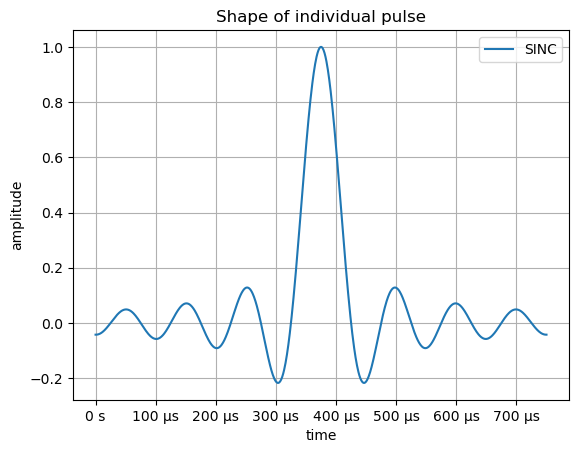

In [3]:
vsinc = np.sinc(Rb*(time-t_disp))

#Apply a hanning window function for better frequency resolution
#vsinc = np.multiply(vsinc,np.hanning(len(vsinc)))

fig, ax = plt.subplots()
plt.plot(time,vsinc,label='SINC')
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlabel("time")
plt.ylabel("amplitude")
formatter0 = EngFormatter(unit='s') #formats units to eng notation
ax.xaxis.set_major_formatter(formatter0) #set formatter to plot
plt.grid()
plt.title("Shape of individual pulse")
plt.legend()

### FFT Parameters 

In [4]:
#parameters for FFT
count = len(vsinc)
values = np.arange(int(count/2))
time_period = count/f_sampling
frequencies = values/time_period

print("FFT PARAMETERS")
print("Length of sinal (must be the equals numPoints):")
print(count)
print("Sample of the frequency components:")
print(values[:10])
print("FFT time window length:")
print(Quantity(time_period,'s'))
print("Sample of the array of frequencies (Hz):")
print(frequencies[:10])
print("Length of frequencies array:")
print(len(frequencies))

FFT PARAMETERS
Length of sinal (must be the equals numPoints):
960
Sample of the frequency components:
[0 1 2 3 4 5 6 7 8 9]
FFT time window length:
750 us
Sample of the array of frequencies (Hz):
[    0.          1333.33333333  2666.66666667  4000.
  5333.33333333  6666.66666667  8000.          9333.33333333
 10666.66666667 12000.        ]
Length of frequencies array:
480


### FFT Plot of sinc pulse

* We can observe the Gibb's Phenomenon due to the window truncation of the sinc pulse;
* It appears as a ripple effect in the spectrum of the pulse;
* This can be mitigated with a root-raised cosine pulse, which will be shown next.
* **CAUTION:** To increase the FFT resolution, we need to increase the number of times we will exceed the bandwidth of the signal $R_b$ by adjusting the variable "oversamp". If "oversamp=2", we are at the Nyquist limit, and the FTT resolution will be poor. 
* Usually, "oversamp=2" might be used to generate the income pulses for the pulse train bipolar transmission;

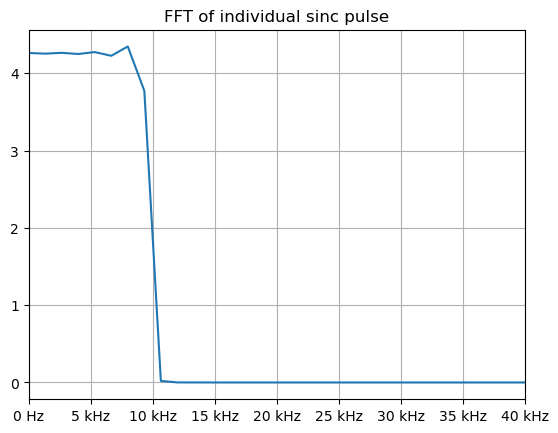

In [5]:
vsinc_fft = np.fft.fft(vsinc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
frequencies = np.fft.fftfreq(vsinc.size,1/f_sampling) #gets the vector of positive frequencies

fig, ax = plt.subplots()
plt.plot(frequencies[:int(frequencies.size/2)],abs(vsinc_fft[:int(frequencies.size/2)])**2,label = "SINC") #plots power spectrum
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlim([0,2*Rb]) #defines frequency limit
plt.grid()
plt.title("FFT of individual sinc pulse")
formatter0 = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter0)

### Root cosine pulse (RC)

Generally speaking, the RRC pulse $h(t)$ is a sinc filter multiplied by an attenuation factor in the form:

$ h(t) = sinc(R_bt) \cos(\pi t r R_b) \dfrac{\cos(\pi t r R_b)}{1 - 4 r^2 t^2 {R_b}^2}$

Where:
* $r$ is the roll-of factor that controls the ripple of the spectrum lobe, also its rate of decay;
* $R_b$ is the bandwidth of the signal;
* $t$ is the time array;
* The roll-off factor is chosen so it attenuates the ripple effect in the spectrum. However, it also changes the effective bandwidth of the signal.
* The effective bandwidth of the RCC pulse is calculate through the following equation

$R_b(\mathrm{RCC}) = (1-r)R_b$



### Comparision between pulses in time

GridSpec(1, 1)

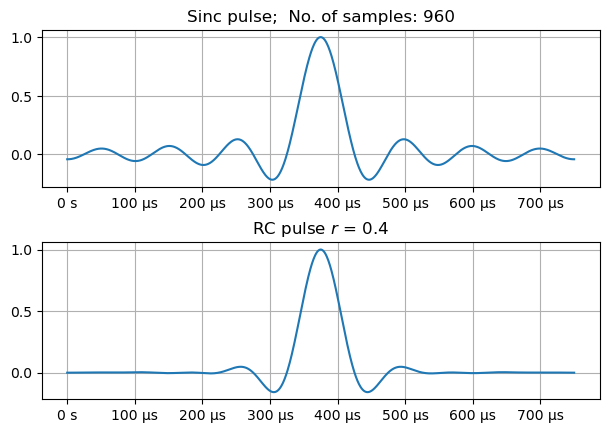

In [26]:
#roll-of factor 
r = 0.4
#rrc filter on time domain
h_rrc = vsinc * (np.cos(np.pi*(time-t_disp)*r*Rb)) / (1 - 4 * r**2 * (time-t_disp)**2 * Rb**2)

##ploting both filters
fig, axs = plt.subplots(2)
axs[0].plot(time,vsinc)
axs[0].set_title("Sinc pulse; " + " No. of samples: {}".format(k*oversamp))
axs[0].grid()
axs[1].plot(time,h_rrc)
axs[1].set_title("RC pulse $r$ = {}".format(r))
axs[1].grid()
axs[0].set_label("time (s)")
axs[1].set_label("time (s)")
#adjust xlabel ticks for Eng Formatter in seconds
formatter0 = EngFormatter(unit='s')
axs[0].xaxis.set_major_formatter(formatter0)
axs[1].xaxis.set_major_formatter(formatter0)
# shift subplots down to adjust titles
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.add_gridspec()


### FFT of RRC pulse


* The next plot shows the RCC pulse spectrum along with the bandwidth of the signal.

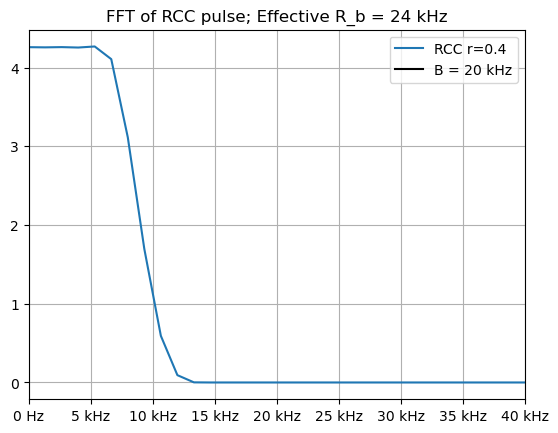

In [7]:
h_rrc_fft = np.fft.fft(h_rrc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
frequencies = np.fft.fftfreq(h_rrc.size,1/f_sampling) #gets the vector of positive frequencies

fig, ax = plt.subplots()
plt.plot(frequencies[:int(frequencies.size/2)],abs(h_rrc_fft[:int(frequencies.size/2)])**2, label = "RCC r={}".format(r)) #plots power spectrum
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlim([0,2*Rb]) #defines frequency limit
plt.axvline(x=50e3, color='k',label='B = {}'.format(Quantity(Rb,'Hz'))) #adds a dark horizontal line to mark the bandwidth
plt.grid()
plt.legend()
plt.title("FFT of RCC pulse; Effective R_b = {}".format(Quantity((1-r)*2*Rb,'Hz')))
formatter0 = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter0)

### Comparison between spectrums

* We can see the RCC pulse operating on the ripple effect of the spectrum, in exchange of effective bandwidth of the signal.

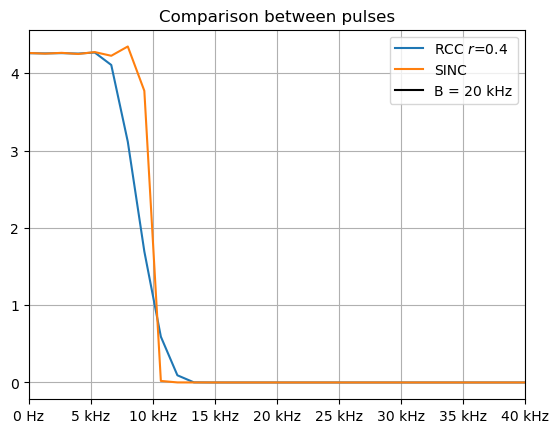

In [8]:
fig, ax = plt.subplots()
plt.plot(frequencies[:int(frequencies.size/2)],abs(h_rrc_fft[:int(frequencies.size/2)])**2,label = "RCC $r$={}".format(r)) #power spectrum rcc pulse
plt.plot(frequencies[:int(frequencies.size/2)],abs(vsinc_fft[:int(frequencies.size/2)])**2,label = "SINC") #power spectrum sinc pulse
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlim([0,2*Rb]) #defines frequency limit
plt.axvline(x=50e3, color='k',label='B = {}'.format(Quantity(Rb,'Hz'))) #adds a dark horizontal line to mark the bandwidth
plt.grid() #grid on
plt.title("Comparison between pulses")
plt.legend()
formatter0 = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter0)

### Comparison between roll-off factors

The next plot shows the differences in the spectrum of the RCC pulse for some different values of $r$

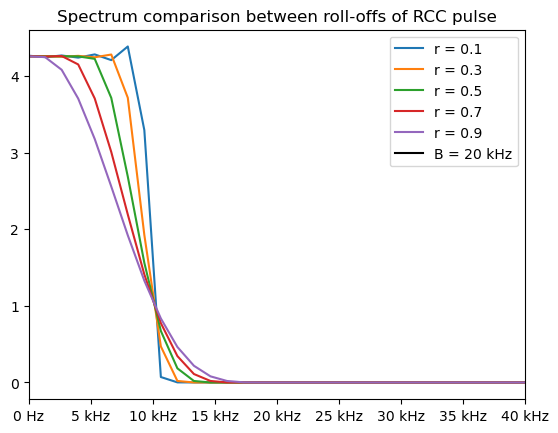

In [27]:
roll_off_factors = [0.1,0.3,0.5,0.7,0.9]
fig, ax = plt.subplots()
for r in roll_off_factors:
    h_rrc = vsinc * (np.cos(np.pi*(time-t_disp)*r*Rb)) / (1 - 4 * r**2 * (time-t_disp)**2 * Rb**2)
    h_rrc_fft = np.fft.fft(h_rrc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
    frequencies = np.fft.fftfreq(h_rrc.size,1/f_sampling) #gets the vector of positive frequencies
    plt.plot(frequencies[:int(frequencies.size/2)],abs(h_rrc_fft[:int(frequencies.size/2)])**2, label = "r = {}".format(r)) #plots power spectrum
plt.xlim([0,2*Rb]) #defines frequency limit
plt.title("Spectrum comparison between roll-offs of RCC pulse")
plt.axvline(x=50e3, color='k',label='B = {}'.format(Quantity(Rb,'Hz'))) #adds a dark horizontal line to mark the bandwidth
formatter0 = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter0)
plt.legend()


**Partial conclusions on the roll-off factor:**
* $r = 0.3$ shows a good attenuation wile mantainig a minor bandwidth reduction (about 70% of desired bandwidth on naked eye observation);

### Plot of Spectra in log base

* The following code and plots show a comparision between the sinc and rcc pulses in a log base 

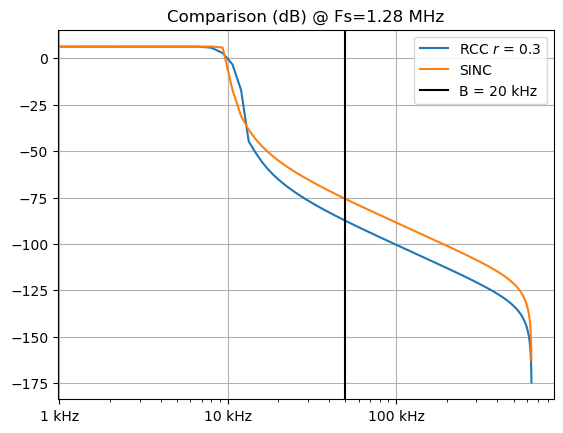

In [10]:
#roll-of factor 
r = 0.3
#rrc filter in time domain now with roll-of = 0.3
h_rrc= vsinc * (np.cos(np.pi*(time-t_disp)*r*Rb)) / (1 - 4 * r**2 * (time-t_disp)**2 * Rb**2) 
vsinc_fft = np.fft.fft(vsinc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
h_rrc_fft = np.fft.fft(h_rrc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
#compute log scale in dB
h_rcc_logscale = 20*np.log10(abs(h_rrc_fft))
vsinc_logscale = 20*np.log10(abs(vsinc_fft))

'''
# visualization of log magnitude data stream
print("Sample Visualization of log magnitude of RCC:")
print(h_rcc_logscale[0:10])
print("Sample Visualization of log magnitude of SINC:")
print(vsinc_logscale[0:10])
'''

#Plot frequency logscale of magnitude in dB 
fig, ax = plt.subplots()
plt.plot(frequencies[:int(frequencies.size/2)],h_rcc_logscale[:int(frequencies.size/2)],label = "RCC $r$ = {}".format(r)) #power spectrum rcc pulse
plt.plot(frequencies[:int(frequencies.size/2)],vsinc_logscale[:int(frequencies.size/2)],label = "SINC") #power spectrum sinc pulse
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
#plt.xlim([0,2*bw_Hz]) #defines frequency limit
plt.grid() #grid on
plt.title("Comparison (dB) @ Fs={}".format(Quantity(f_sampling,'Hz')))
ax.set_xscale("log")
formatter0 = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter0)
plt.axvline(x=50e3, color='k',label='B = {}'.format(Quantity(Rb,'Hz'))) #adds a dark horizontal line to mark the bandwidth
plt.legend()

* Now, a comparison of the same plot at the vicinity of the bandwidth in order to see the ripple on the spectrum:

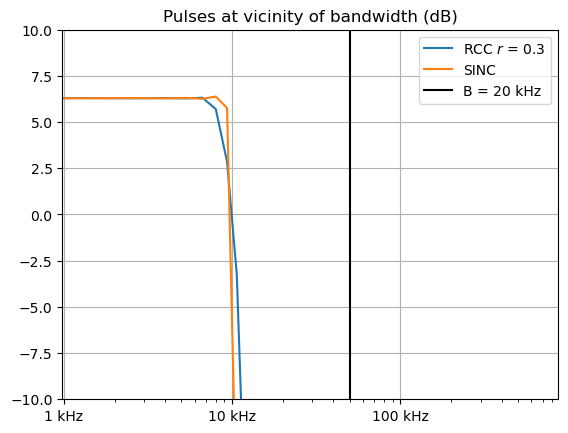

In [11]:
#Plot frequency logscale of magnitude in dB 
fig, ax = plt.subplots()
plt.plot(frequencies[:int(frequencies.size/2)],h_rcc_logscale[:int(frequencies.size/2)],label = "RCC $r$ = {}".format(r)) #power spectrum rcc pulse
plt.plot(frequencies[:int(frequencies.size/2)],vsinc_logscale[:int(frequencies.size/2)],label = "SINC") #power spectrum sinc pulse
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.ylim([-10,10]) #defines frequency limit
plt.grid() #grid on
plt.title("Pulses at vicinity of bandwidth (dB)")
ax.set_xscale("log")
formatter0 = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter0)
plt.axvline(x=50e3, color='k',label='B = {}'.format(Quantity(Rb,'Hz'))) #adds a dark horizontal line to mark the bandwidth
plt.legend()

## Polar signaling

* The line code controls the way the modulation scheme will affect the pulse's properties in order to transmit digital data;
* In general, a line code is dependent on two things:
    1) The autorrelation function between the transmitted pulses. I.e, the "transmittion pattern" of the code;
    2) The pulse shape $p(t)$ used for transmission.
* In this notebook, we will refer as the *polar signaling* as the main line code used;

## Transmitting a pulse sequence over distortionless channel


* The next sections showed how to develop a Sinc pulse, a Nyquist pulse, and a more usable pulse, called the RCC pulse; 
* This sectin shows to properly build a message signal by utilizing both pulses;

### Generating Polar Bit Stream

* This section shows to generate a bit stream, and how to visualize the bit distributions using a pandas frame;
* The final result is an int array containing a dummy vector of 0s and 1s to represent the bit stream;
* in polar signaling, bit 1 is transmitted by a pulse $p(t)$, while bit 0 is transmitted by a pulse $-p(t)$;
* The first to do is to generate an impulse train of 1s and -1s at the pulse's sampling frequency.

In [12]:
import pandas as pd
#Generate random bit sequence
numBits = 20 #number of bits desired to transmit
noise = np.random.normal(0,1,numBits) #generates random noise
df = pd.DataFrame(np.sign(noise),columns=['polar']) #assigns a pandas dataframe of boolean type
polar = df[['polar']].to_numpy() #gets the array data
df.head(10) #displays the dataframe for visualization


,polar
0,-1.0
1,1.0
2,-1.0
3,1.0
4,1.0
5,-1.0
6,1.0
7,1.0
8,-1.0
9,1.0


Text(0.5, 1.0, 'Symbol distribution of 20 bit stream')

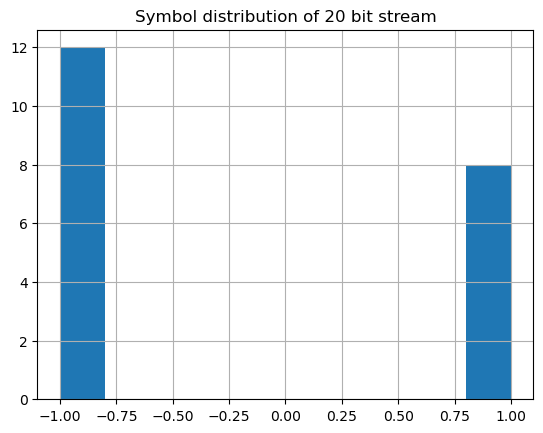

In [13]:
#Check if bitstream contains a regular distribution of bits 1s and 0s in polar form
df.hist()
plt.title("Symbol distribution of {}".format(numBits) + " bit stream")

In [14]:
#upsampling to get pulse train of line code
pointsPerSymbol = round(f_sampling/Rb)
t_init = 0
t_end = pointsPerSymbol*numBits*t_step
#time pulse array
time_pulse = np.linspace(t_init,t_end,pointsPerSymbol*numBits)
impulse_train = np.zeros(pointsPerSymbol*numBits) #assigns memory to pulse train
bit_index = 0 #tracks the bit index
for bits in polar:
    for j in np.zeros(pointsPerSymbol):
        impulse_train[bit_index*pointsPerSymbol] = bits
        impulse_train[bit_index*pointsPerSymbol+1:(pointsPerSymbol)] = j
    bit_index = bit_index + 1    
#definetely not the best solution... but works and I'm in a hurry
del bit_index #eliminates dummy variable for track bit index
#df.head() #displays the dataframe for visualization

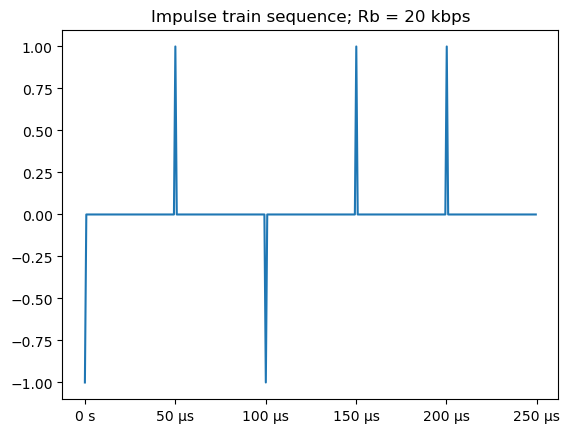

In [15]:
#plot the first 5 impulses for eye verification
fig, ax = plt.subplots()
plt.plot(time_pulse[0:pointsPerSymbol*5],impulse_train[0:pointsPerSymbol*5])
plt.title("Impulse train sequence;" + " Rb = {}".format(Quantity(Rb,'bps')))
formatter0 = EngFormatter(unit='s')
ax.xaxis.set_major_formatter(formatter0)

In [29]:
#generating binary data with rectangular pulse train
rect = np.ones(round(pointsPerSymbol)) #rectangular pulse 
#generating rectangular pulse train
pulse_train_rect = np.convolve(impulse_train,rect)
#adjust lengths (eliminating convolution delay)
pulse_train_rect = pulse_train_rect[0:len(time_pulse)]

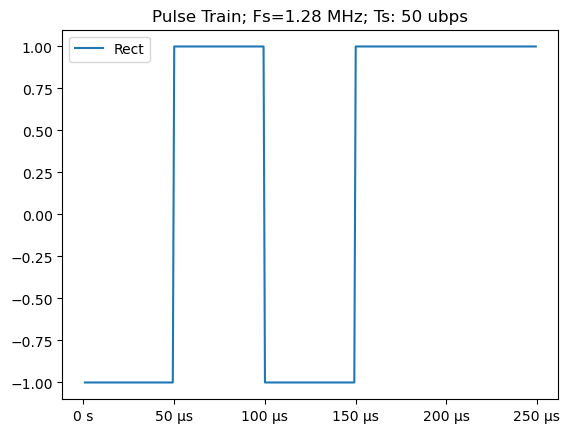

In [17]:
#Plot of rectangular pulse train
fig, ax = plt.subplots()
plt.plot(time_pulse[1:5*pointsPerSymbol],pulse_train_rect[1:5*pointsPerSymbol],label="Rect")
formatter0 = EngFormatter(unit='s')
ax.xaxis.set_major_formatter(formatter0)
plt.title("Pulse Train; Fs={}".format(Quantity(f_sampling,'Hz'))+"; Ts: {}".format(Quantity(1/Rb,'bps')))
plt.legend()

### Generate Filter Impulse Response

In [30]:
from commpy.filters import rrcosfilter

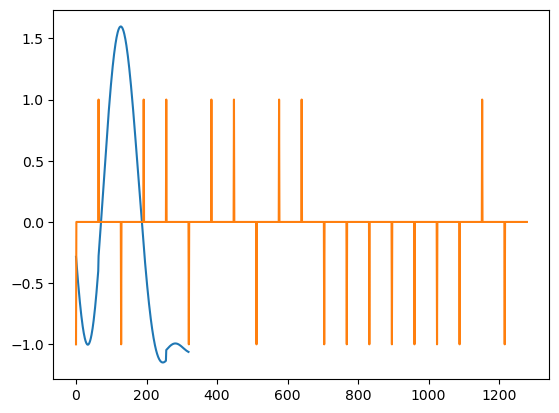

In [19]:
pulse_train_rc = pulse_train_rc[len(vsinc):len(impulse_train)]
plt.plot(pulse_train_rc)
plt.plot(impulse_train)

ValueError: x and y must have same first dimension, but have shapes (1280,) and (320,)

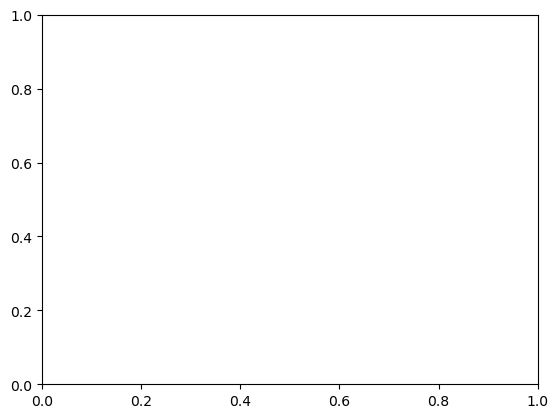

In [20]:
fig, ax = plt.subplots()
windowPlotLength = pointsPerSymbol*vsinc.size
plt.plot(time_pulse,pulse_train_rc,label = "RCC $r$ = {}".format(r))
plt.plot(time_pulse,pulse_train_rect,label="Rect")
formatter0 = EngFormatter(unit='s')
ax.xaxis.set_major_formatter(formatter0)
plt.title("Comparison; Fs={}".format(Quantity(f_sampling,'Hz'))+"; Data-rate: {}".format(Quantity(Rb,'bps')))
plt.legend()

In [ ]:
#plot first 5 symbols being transmitted of all arrays
fig, ax = plt.subplots()
windowPlotLength = pointsPerSymbol*vsinc.size
plt.plot(time_pulse[1:5*windowPlotLength],pulse_train_rc[1:5*windowPlotLength],label = "RCC $r$ = {}".format(r))
plt.plot(time_pulse[vsinc.size:5*windowPlotLength],pulse_train_rect[vsinc.size:5*windowPlotLength],label="Rect")
#plt.plot(time_pulse[1:5*numPoints],pulse_train_sine[1:5*numPoints],label="Sine")
formatter0 = EngFormatter(unit='s')
ax.xaxis.set_major_formatter(formatter0)
plt.title("Comparison; Fs={}".format(Quantity(f_sampling,'Hz'))+"; Data-rate: {}".format(Quantity(1/t_end,'bps')))
plt.legend()

## Further Examples

* Link to future Welch Spectrum Plot of data
https://numpy.org/doc/stable/reference/generated/numpy.sinc.html
* Next steps: 
* Define a big bit-sequence and plot its Power Spectral Density
* For this, we have to defined well-behaved pulse trains that must be pratical for a real application;
* In the next section, we will exclude the FFT codes from the pulse spectrum and will concentrate on generating a sequence of data pulses.

## References

[1] Ding, Z., Lathi, B. P. *Modern Digital and Analog Communication Systems*. 5th ed. LTC, 2019.

[2] Ricketts, D. S. *Module 5 Modulation Bandwidth and Pulse Filtering* [video]. Youtube: https://youtu.be/F4QUWj7XYSI

## Generating pulse train for Simulation